In [1]:
import pandas as pd
import numpy as np
import torch
import os
import zipfile
import sys
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
 
    
sys.path.insert(1, '../../tsad/')
from tsad.useful.ts import ts_train_test_split     
from tsad.models.fit import fit, set_determenistic
from torch import nn, optim
import torch
import numpy as np
from tsad.models.lstm import SimpleLSTM
from sklearn.preprocessing import StandardScaler
from tsad.useful.iterators import Loader
    
from statsmodels.tsa.arima.model import ARIMA
from tqdm import tqdm
import warnings 
warnings.filterwarnings("ignore")
from catboost import CatBoostRegressor


In [2]:
fname = 'skab.zip'
if not os.path.exists('skab.zip'):
    import requests
    url = 'https://github.com/waico/SKAB/archive/refs/heads/master.zip'
    r = requests.get(url)
    open(fname , 'wb').write(r.content)

In [3]:
z = zipfile.ZipFile(fname)
train_datasets = []
test_datasets  = []
for file  in z.namelist():
    if '.csv' in file:
        if 'anomaly-free' in file:
            test_datasets.append(pd.read_csv(z.open(file),index_col='datetime',sep=';',parse_dates=True))
        else:
            train_datasets.append(pd.read_csv(z.open(file),index_col='datetime',sep=';',parse_dates=True).drop(columns= ['anomaly','changepoint']))

scaler = StandardScaler().fit(pd.concat(train_datasets+test_datasets))
train_datasets = [pd.DataFrame(scaler.transform(df),index=df.index,columns=df.columns) for df in train_datasets]
test_datasets = [pd.DataFrame(scaler.transform(df),index=df.index,columns=df.columns) for df in test_datasets]

In [4]:
X_train_ts = []
y_train_ts = []
for df in train_datasets:
    sets = ts_train_test_split(df,30,test_size=0)
    X_train_ts+=sets[0]
    y_train_ts+=sets[2]

sets = ts_train_test_split(test_datasets[0],30,test_size=0)
X_test_ts=sets[0]
y_test_ts=sets[2]

# Gradient Boosting

In [123]:
def median(x):
    return x.median()

def last_value(x):
    return x.iloc[-1]

def first_value(x):
    return x.iloc[0]

def q025(x):
    return x.apply(lambda var: np.quantile(var,0.25))

def q075(x):
    return x.apply(lambda var: np.quantile(var,0.75))

def diff_mean(x):
    return x.diff().mean()

def diff_min(x):
    return x.diff().min()

def diff_max(x):
    return x.diff().max()

def diff_sum(x):
    return x.diff().sum()


def lin_koef(x):
    all_df = []
    for col in x:
        ms = x.reset_index()[col]
        reg = LinearRegression().fit(np.array(ms.index).reshape(-1, 1),
                                     ms.values.reshape(-1, 1))
        all_df.append(pd.Series([reg.coef_[0][0],reg.intercept_[0]],index=['a_koef'+'-'+col,'b_koef'+'-'+col ]))
    return pd.concat(all_df)

def get_fft_features_from_df(x):
    return pd.concat([pd.Series(x.apply(lambda ts: np.real(np.fft.fft(ts)[:5])).values.ravel(),
                                index = ['fft_real'+str(i) for i in range(x.shape[1]*5)]),
                      pd.Series(x.apply(lambda ts: np.imag(np.fft.fft(ts)[:5])).values.ravel(),
                                index = ['fft_img'+str(i) for i in range(x.shape[1]*5)])])

functions = [np.mean,
             np.max,
             np.min,
             median,
             np.sum, 
             q025,
             q075,
             last_value, 
             first_value,
             diff_mean,
             diff_min,
             diff_max,
             diff_sum,
             lin_koef,
             get_fft_features_from_df,
            ] 

def generate_feature(batch,portion=1):
    new_batch = []
    for mini_df in batch:
        new_raw = []
        for function in functions:
            new_raw.append(function(mini_df[-int(len(df)*portion):]).add_prefix(str(function).split(' ')[1]+'-'))
        new_raw = pd.concat(new_raw).to_frame().T
        new_batch.append(new_raw)
    new_batch = pd.concat(new_batch)
    return new_batch


In [ ]:
X_train = pd.concat([generate_feature(X_train_ts,portion=1),
                 generate_feature(X_train_ts,portion=1/7).add_prefix('22_'),
                 generate_feature(X_train_ts,portion=1/7/6).add_prefix('33_')],1)
X_test = pd.concat([generate_feature(X_test_ts,portion=1),
                     generate_feature(X_test_ts,portion=1/7).add_prefix('22_'),
                     generate_feature(X_test_ts,portion=1/7/6).add_prefix('33_')],1)
y_train = np.concatenate([df.values for df in y_train_ts])
y_test  = np.concatenate([df.values for df in y_test_ts])

In [131]:
reg = CatBoostRegressor(loss_function='MultiRMSE', verbose=False)
reg.fit(X_train,y_train)
y_pred = reg.predict(X_test)
RMSE = mse(y_pred,y_test,squared=False)
print(f'RMSE={RMSE:.2f}')

RMSE=0.39


# ARIMA

In [78]:
preds = []
trues = []
for col in df:
    for i in tqdm(range(window,len(df))):
        try:
            ts = df[col][:i]
            model = ARIMA(ts[:i], order=(30,1,0))
            res = model.fit()
            preds.append(res.forecast(1).values)
            trues.append(df[col][i:i+1].values)
        except:
            pass
RMSE = mse(np.array(preds),np.array(trues),squared=False)
print(f'RMSE={RMSE:.2f}')

RMSE=0.47


# DMLP

In [68]:
class DMLP(nn.Module):
    def __init__(self, in_features, n_hidden, n_output, seed=None):
        set_determenistic(seed)
        super(DMLP, self).__init__()
        middle1 = int(1/2*(n_hidden+in_features))
        middle2 = int(1/2*(n_hidden+n_output))
        
        self.sig = torch.nn.functional.sigmoid
        
        self.linear1 = nn.Linear(in_features=in_features, out_features=middle1 )
        self.linear2 = nn.Linear(in_features=middle1, out_features=n_hidden)   
        self.linear3 = nn.Linear(in_features=n_hidden, out_features=middle2)   
        self.linear4 = nn.Linear(in_features=middle2, out_features=n_output)   
    

    def forward(self, x):
        x = self.sig(self.linear1(x))
        x = self.sig(self.linear2(x))
        x = self.sig(self.linear3(x))
        out = self.linear4(x)
        return out
    

    def run_epoch(self, iterator, optimizer, criterion, points_ahead=1, phase='train', device=torch.device('cuda:0'), encod_decode_model=False):
        self.to(device)
        
        is_train = (phase == 'train')
        if is_train:
            self.train()
        else:
            self.eval()
        
        epoch_loss = 0
        

        all_y_preds = []
        with torch.set_grad_enabled(is_train):
            for i, (x,y) in enumerate(iterator):
                x,y = np.array(x),np.array(y) #df.index rif of
                
                x = torch.tensor(x).float().to(device).requires_grad_().squeeze()
                y_true = torch.tensor(y).float().to(device)
                y_pred = self.forward(x).unsqueeze(1)                

                if phase == 'forecast':
                    all_y_preds.append(y_pred)
                    continue # in case of pahse = 'forecast' criterion is None
                        
                loss = criterion(y_pred,y_true)
                if is_train:
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                epoch_loss += loss.item()
        if phase != 'forecast':
            return epoch_loss / len(iterator)#, n_true_predicted / n_predicted
        else:
            return torch.cat(all_y_preds).detach().cpu().numpy()


In [69]:
res_train_test_split = ([df.values.ravel().reshape(1,-1) for df in X_train_ts],
                        [df.values.ravel().reshape(1,-1) for df in X_test_ts],
                        [df.values for df in y_train_ts],
                        [df.values for df in y_test_ts]
                       )

In [70]:
inp_size = res_train_test_split[0][0].shape[1]
out_size = res_train_test_split[-1][0].shape[1]
model = DMLP(inp_size,out_size,out_size)
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(f'Net paramaeters: {pytorch_total_params}')
print(f'Samples: {len(res_train_test_split[0])}')

Net paramaeters: 31028
Samples: 36381


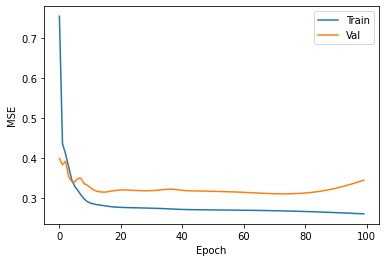

Epoch: 100 
	Train Loss: 0.261 
	 Val. Loss: 0.346 

Epoch: 99 
	Train Loss: 0.261 
	 Val. Loss: 0.343 

Epoch: 98 
	Train Loss: 0.262 
	 Val. Loss: 0.340 

Epoch: 97 
	Train Loss: 0.262 
	 Val. Loss: 0.338 

Epoch: 96 
	Train Loss: 0.262 
	 Val. Loss: 0.336 

Epoch: 95 
	Train Loss: 0.263 
	 Val. Loss: 0.333 

Epoch: 94 
	Train Loss: 0.263 
	 Val. Loss: 0.331 

Epoch: 93 
	Train Loss: 0.263 
	 Val. Loss: 0.329 

Epoch: 92 
	Train Loss: 0.264 
	 Val. Loss: 0.327 

Epoch: 91 
	Train Loss: 0.264 
	 Val. Loss: 0.325 

Epoch: 90 
	Train Loss: 0.264 
	 Val. Loss: 0.324 

Epoch: 89 
	Train Loss: 0.265 
	 Val. Loss: 0.322 

Epoch: 88 
	Train Loss: 0.265 
	 Val. Loss: 0.320 

Epoch: 87 
	Train Loss: 0.265 
	 Val. Loss: 0.319 

Epoch: 86 
	Train Loss: 0.266 
	 Val. Loss: 0.318 

Epoch: 85 
	Train Loss: 0.266 
	 Val. Loss: 0.317 

Epoch: 84 
	Train Loss: 0.266 
	 Val. Loss: 0.316 

Epoch: 83 
	Train Loss: 0.266 
	 Val. Loss: 0.315 

Epoch: 82 
	Train Loss: 0.267 
	 Val. Loss: 0.314 

Epoch: 81 


0.3111343335460972

In [71]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())


fit(model,
    optimiser=optimizer,
    criterion=criterion,
    res_train_test_split=res_train_test_split,
    n_epochs=100,
    batch_size=128,
    best_model_file='./best_ae.pth',
    points_ahead=1,
    random_state=777,)

In [78]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
y_pred_test =  model.run_epoch(Loader(res_train_test_split[1],res_train_test_split[0],32), optimizer=None, criterion=None, phase='forecast').squeeze(1)
RMSE = mse(y_pred_test,np.squeeze(res_train_test_split[-1],1),squared=False)
print(f'RMSE={RMSE:.2f}')

RMSE=0.47


# AE

In [80]:
inp_size = res_train_test_split[0][0].shape[1]
out_size = res_train_test_split[-1][0].shape[1]
hidden_size= int(res_train_test_split[-1][0].shape[1]/2)

model = DMLP(inp_size,hidden_size,out_size)
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(f'Net paramaeters: {pytorch_total_params}')
print(f'Samples: {len(res_train_test_split[0])}')

Net paramaeters: 29980
Samples: 36381


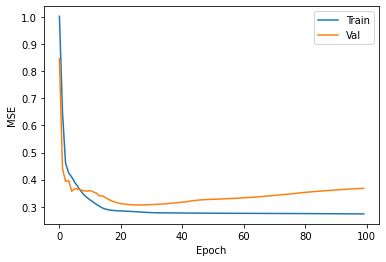

Epoch: 100 
	Train Loss: 0.273 
	 Val. Loss: 0.368 

Epoch: 99 
	Train Loss: 0.273 
	 Val. Loss: 0.367 

Epoch: 98 
	Train Loss: 0.274 
	 Val. Loss: 0.367 

Epoch: 97 
	Train Loss: 0.274 
	 Val. Loss: 0.366 

Epoch: 96 
	Train Loss: 0.274 
	 Val. Loss: 0.366 

Epoch: 95 
	Train Loss: 0.274 
	 Val. Loss: 0.365 

Epoch: 94 
	Train Loss: 0.274 
	 Val. Loss: 0.364 

Epoch: 93 
	Train Loss: 0.274 
	 Val. Loss: 0.364 

Epoch: 92 
	Train Loss: 0.274 
	 Val. Loss: 0.363 

Epoch: 91 
	Train Loss: 0.274 
	 Val. Loss: 0.362 

Epoch: 90 
	Train Loss: 0.274 
	 Val. Loss: 0.361 

Epoch: 89 
	Train Loss: 0.274 
	 Val. Loss: 0.360 

Epoch: 88 
	Train Loss: 0.274 
	 Val. Loss: 0.359 

Epoch: 87 
	Train Loss: 0.274 
	 Val. Loss: 0.358 

Epoch: 86 
	Train Loss: 0.274 
	 Val. Loss: 0.358 

Epoch: 85 
	Train Loss: 0.274 
	 Val. Loss: 0.357 

Epoch: 84 
	Train Loss: 0.274 
	 Val. Loss: 0.356 

Epoch: 83 
	Train Loss: 0.275 
	 Val. Loss: 0.355 

Epoch: 82 
	Train Loss: 0.275 
	 Val. Loss: 0.354 

Epoch: 81 


0.30637951537563995

In [81]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())


fit(model,
    optimiser=optimizer,
    criterion=criterion,
    res_train_test_split=res_train_test_split,
    n_epochs=100,
    batch_size=128,
    best_model_file='./best_ae.pth',
    points_ahead=1,
    random_state=777,)

In [82]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
y_pred_test =  model.run_epoch(Loader(res_train_test_split[1],res_train_test_split[0],32), optimizer=None, criterion=None, phase='forecast').squeeze(1)
RMSE = mse(y_pred_test,np.squeeze(res_train_test_split[-1],1),squared=False)
print(f'RMSE={RMSE:.2f}')

RMSE=0.45


# CNN

In [132]:
class CNN(nn.Module):  
    
    def __init__(self, seed=None):
        set_determenistic(seed)
        super(CNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=7, kernel_size=3, stride=1, padding=0)
        self.fc1 = nn.Linear(182, 8)
    

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = nn.functional.relu(self.conv2(x))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        out = self.fc1(x)
        return out
    

    def run_epoch(self, iterator, optimizer, criterion, points_ahead=1, phase='train', device=torch.device('cuda:0'), encod_decode_model=False):
        self.to(device)
        
        is_train = (phase == 'train')
        if is_train:
            self.train()
        else:
            self.eval()
        
        epoch_loss = 0
        

        all_y_preds = []
        with torch.set_grad_enabled(is_train):
            for i, (x,y) in enumerate(iterator):
                x,y = np.array(x),np.array(y) #df.index rif of
                
                x = torch.tensor(x).float().to(device).requires_grad_().squeeze()
                y_true = torch.tensor(y).float().to(device)
                y_pred = self.forward(x).unsqueeze(1)                

                if phase == 'forecast':
                    all_y_preds.append(y_pred)
                    continue # in case of pahse = 'forecast' criterion is None
                        
                loss = criterion(y_pred,y_true)
                if is_train:
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                epoch_loss += loss.item()
        if phase != 'forecast':
            return epoch_loss / len(iterator)#, n_true_predicted / n_predicted
        else:
            return torch.cat(all_y_preds).detach().cpu().numpy()


In [133]:
res_train_test_split = ([df.values for df in X_train_ts],
                        [df.values for df in X_test_ts],
                        [df.values for df in y_train_ts],
                        [df.values for df in y_test_ts]
                       )

In [134]:
inp_size = res_train_test_split[0][0].shape[1]
out_size = res_train_test_split[-1][0].shape[1]
model = CNN()
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(f'Net paramaeters: {pytorch_total_params}')
print(f'Samples: {len(res_train_test_split[0])}')

Net paramaeters: 1690
Samples: 36381


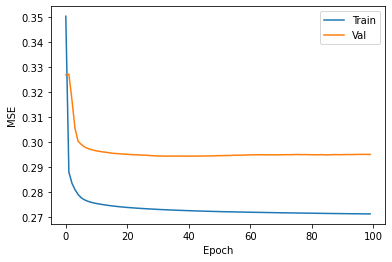

Epoch: 100 
	Train Loss: 0.271 
	 Val. Loss: 0.295 

Epoch: 99 
	Train Loss: 0.271 
	 Val. Loss: 0.295 

Epoch: 98 
	Train Loss: 0.271 
	 Val. Loss: 0.295 

Epoch: 97 
	Train Loss: 0.271 
	 Val. Loss: 0.295 

Epoch: 96 
	Train Loss: 0.271 
	 Val. Loss: 0.295 

Epoch: 95 
	Train Loss: 0.271 
	 Val. Loss: 0.295 

Epoch: 94 
	Train Loss: 0.271 
	 Val. Loss: 0.295 

Epoch: 93 
	Train Loss: 0.271 
	 Val. Loss: 0.295 

Epoch: 92 
	Train Loss: 0.271 
	 Val. Loss: 0.295 

Epoch: 91 
	Train Loss: 0.271 
	 Val. Loss: 0.295 

Epoch: 90 
	Train Loss: 0.271 
	 Val. Loss: 0.295 

Epoch: 89 
	Train Loss: 0.271 
	 Val. Loss: 0.295 

Epoch: 88 
	Train Loss: 0.271 
	 Val. Loss: 0.295 

Epoch: 87 
	Train Loss: 0.271 
	 Val. Loss: 0.295 

Epoch: 86 
	Train Loss: 0.271 
	 Val. Loss: 0.295 

Epoch: 85 
	Train Loss: 0.271 
	 Val. Loss: 0.295 

Epoch: 84 
	Train Loss: 0.271 
	 Val. Loss: 0.295 

Epoch: 83 
	Train Loss: 0.271 
	 Val. Loss: 0.295 

Epoch: 82 
	Train Loss: 0.271 
	 Val. Loss: 0.295 

Epoch: 81 


0.2942940705531352

In [135]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())


fit(model,
    optimiser=optimizer,
    criterion=criterion,
    res_train_test_split=res_train_test_split,
    n_epochs=100,
    batch_size=128,
    best_model_file='./best_ae.pth',
    points_ahead=1,
    random_state=777,)

In [136]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
y_pred_test =  model.run_epoch(Loader(res_train_test_split[1],res_train_test_split[0],32), optimizer=None, criterion=None, phase='forecast').squeeze(1)
RMSE = mse(y_pred_test,np.squeeze(res_train_test_split[-1],1),squared=False)
print(f'RMSE={RMSE:.2f}')

RMSE=0.41


# LSTM 

In [83]:
class SimpleLSTM(nn.Module):
    def __init__(self, in_features, n_hidden, n_layers=3, bidirectional=False, dropout=0.5, seed=None):
        set_determenistic(seed)
        super(SimpleLSTM, self).__init__()
        self.in_features = in_features
        self.n_hidden = n_hidden
        self.n_layers = n_layers
        self.lstm = nn.LSTM(input_size=in_features,
                            hidden_size=n_hidden,
                            num_layers=n_layers,
                            dropout=dropout,
                            batch_first =True,
                            bidirectional = bidirectional
                           )
        self.k_bidir = 2 if bidirectional else 1 

        self.linear = nn.Linear(in_features=n_hidden, out_features=n_hidden)        
    
    
    def initHidden(self,batch_size,device):
        self.hidden = (
            torch.zeros(self.n_layers*self.k_bidir, batch_size, self.n_hidden).to(device),
            torch.zeros(self.n_layers*self.k_bidir, batch_size, self.n_hidden).to(device)
        )
    def forward(self, sequences):
        batch_size  = len(sequences)
        lstm_out, self.hidden = self.lstm(sequences, self.hidden )
        last_time_step = lstm_out.reshape(-1, batch_size, self.n_hidden)[-1] # -1 is len_seq

        y_pred = self.linear(last_time_step)
        return y_pred

    def run_epoch(self, iterator, optimizer, criterion, points_ahead=1, phase='train', device=torch.device('cuda:0'), encod_decode_model=False):
        self.to(device)
        
        is_train = (phase == 'train')
        if is_train:
            self.train()
        else:
            self.eval()
        
        epoch_loss = 0
        
        if points_ahead !=1:
            assert (points_ahead > 0) & (type(points_ahead)==type(int()))
            def forecast_multistep(y_pred,points_ahead):
                new_x = y_pred
                for j in range(points_ahead-1):
                    new_x = self.forward(new_x).unsqueeze(1)
                    y_pred = torch.cat([y_pred,new_x],1)
                return y_pred
        else:
            def forecast_multistep(y_pred,points_ahead):
                return y_pred

        all_y_preds = []
        with torch.set_grad_enabled(is_train):
            for i, (x,y) in enumerate(iterator):
                x,y = np.array(x),np.array(y) #df.index rif of
                self.initHidden(x.shape[0],device=device)
                
                x = torch.tensor(x).float().to(device).requires_grad_()
                y_true = torch.tensor(y).float().to(device)
                y_pred = self.forward(x).unsqueeze(1)
                y_pred = forecast_multistep(y_pred,points_ahead)
                
                if encod_decode_model:
                    y_pred = torch.cat([y_pred[:,i,:].unsqueeze(1) for i in range(y_pred.shape[1]-1,-1,-1)],1)
                
                if phase == 'forecast':
                    all_y_preds.append(y_pred)
                    continue # in case of pahse = 'forecast' criterion is None
                        
                loss = criterion(y_pred,y_true)
                if is_train:
                  optimizer.zero_grad()
                  loss.backward()
                  optimizer.step()

                
                epoch_loss += loss.item()
        if phase != 'forecast':
            return epoch_loss / len(iterator)#, n_true_predicted / n_predicted
        else:
            return torch.cat(all_y_preds).detach().cpu().numpy()




In [85]:
res_train_test_split = (X_train_ts, X_test_ts,  y_train_ts, y_test_ts)

In [86]:
model = SimpleLSTM(res_train_test_split[0][0].shape[1],
                   res_train_test_split[-1][0].shape[1],
                   n_layers=5,
                   dropout=0.0,
                   seed=26)
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(f'Net paramaeters: {pytorch_total_params}')
print(f'Samples: {len(res_train_test_split[0])}')

2952


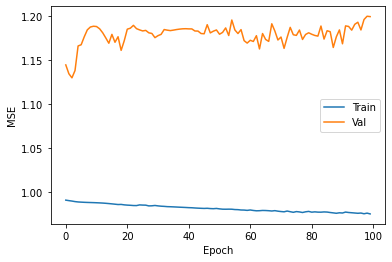

Epoch: 100 
	Train Loss: 0.975 
	 Val. Loss: 1.199 

Epoch: 99 
	Train Loss: 0.976 
	 Val. Loss: 1.200 

Epoch: 98 
	Train Loss: 0.975 
	 Val. Loss: 1.196 

Epoch: 97 
	Train Loss: 0.976 
	 Val. Loss: 1.184 

Epoch: 96 
	Train Loss: 0.975 
	 Val. Loss: 1.193 

Epoch: 95 
	Train Loss: 0.976 
	 Val. Loss: 1.190 

Epoch: 94 
	Train Loss: 0.976 
	 Val. Loss: 1.184 

Epoch: 93 
	Train Loss: 0.976 
	 Val. Loss: 1.188 

Epoch: 92 
	Train Loss: 0.977 
	 Val. Loss: 1.189 

Epoch: 91 
	Train Loss: 0.976 
	 Val. Loss: 1.168 

Epoch: 90 
	Train Loss: 0.976 
	 Val. Loss: 1.184 

Epoch: 89 
	Train Loss: 0.975 
	 Val. Loss: 1.176 

Epoch: 88 
	Train Loss: 0.976 
	 Val. Loss: 1.164 

Epoch: 87 
	Train Loss: 0.976 
	 Val. Loss: 1.182 

Epoch: 86 
	Train Loss: 0.977 
	 Val. Loss: 1.183 

Epoch: 85 
	Train Loss: 0.977 
	 Val. Loss: 1.174 

Epoch: 84 
	Train Loss: 0.977 
	 Val. Loss: 1.188 

Epoch: 83 
	Train Loss: 0.977 
	 Val. Loss: 1.177 

Epoch: 82 
	Train Loss: 0.977 
	 Val. Loss: 1.178 

Epoch: 81 


1.1294832091282658

In [88]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())


fit(model,
    optimiser=optimizer,
    criterion=criterion,
    res_train_test_split=res_train_test_split,
    n_epochs=100,
    batch_size=32,
    best_model_file='./best_ae.pth',
    points_ahead=1,
    random_state=777,)

In [89]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
y_pred_test =  model.run_epoch(Loader(res_train_test_split[1],res_train_test_split[0],32), optimizer=None, criterion=None, phase='forecast').squeeze(1)
RMSE = mse(y_pred_test,np.squeeze(res_train_test_split[-1],1),squared=False)
print(f'RMSE={RMSE:.2f}')

RMSE=1.04


# Attention

Часть кода взята из https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html. Также код адаптирован под задачи временных рядов


In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)
    
    
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        print(input)
        print(f'Input shape {input.shape}')
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        print(f'embedded shape {embedded.shape}')

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        
        print(f'attn_weights shape {attn_weights.shape}')
        print(f'encoder_outputs shape {encoder_outputs.shape}')
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))
        print(f'attn_applied shape {attn_applied.shape}')

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        print(f'output shape {output.shape}')
        output = self.attn_combine(output).unsqueeze(0)
        print(f'output shape {output.shape}')
        print(f'hidden shape {hidden.shape}')

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)
    
       
    
    
    def run_epoch(self, iterator, optimizer, criterion, points_ahead=1, phase='train', device=torch.device('cuda:0'), encod_decode_model=False):
    self.to(device)

    is_train = (phase == 'train')
    if is_train:
        self.train()
    else:
        self.eval()

    epoch_loss = 0

    if points_ahead !=1:
        assert (points_ahead > 0) & (type(points_ahead)==type(int()))
        def forecast_multistep(y_pred,points_ahead):
            new_x = y_pred
            for j in range(points_ahead-1):
                new_x = self.forward(new_x).unsqueeze(1)
                y_pred = torch.cat([y_pred,new_x],1)
            return y_pred
    else:
        def forecast_multistep(y_pred,points_ahead):
            return y_pred

    all_y_preds = []
    with torch.set_grad_enabled(is_train):
        for i, (x,y) in enumerate(iterator):
            x,y = np.array(x),np.array(y) #df.index rif of
            self.initHidden(x.shape[0],device=device)

            x = torch.tensor(x).float().to(device).requires_grad_()
            y_true = torch.tensor(y).float().to(device)
            y_pred = self.forward(x).unsqueeze(1)
            y_pred = forecast_multistep(y_pred,points_ahead)

            if encod_decode_model:
                y_pred = torch.cat([y_pred[:,i,:].unsqueeze(1) for i in range(y_pred.shape[1]-1,-1,-1)],1)

            if phase == 'forecast':
                all_y_preds.append(y_pred)
                continue # in case of pahse = 'forecast' criterion is None

            loss = criterion(y_pred,y_true)
            if is_train:
              optimizer.zero_grad()
              loss.backward()
              optimizer.step()


            epoch_loss += loss.item()
    if phase != 'forecast':
        return epoch_loss / len(iterator)#, n_true_predicted / n_predicted
    else:
        return torch.cat(all_y_preds).detach().cpu().numpy()


In [ ]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    
    print(f'attn_applied shape {max_length}')
    print(f'input_length shape {input_length}')
    print(f'target_length shape {target_length}')
    
    
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing
            break

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break
            break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length